# Demo polars capabilities and interactively develop it

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import polars as pl
import seaborn as sns

from floris import tools as wfct
from floris.utilities import wrap_360


# from flasc.energy_ratio_pandas import energy_ratio_suite
from flasc.energy_ratio import energy_ratio as erp
from flasc.energy_ratio.energy_ratio_input import EnergyRatioInput

from flasc.visualization import plot_layout_with_waking_directions, plot_binned_mean_and_ci




In [5]:
N = 5

### Use FLORIS to generate a wake steering data set

/Users/pfleming/Projects/FLORIS/flasc/flasc/energy_ratio/../examples/floris_input_artificial/gch.yaml


<Axes: xlabel='x coordinate (m)', ylabel='y coordinate (m)'>

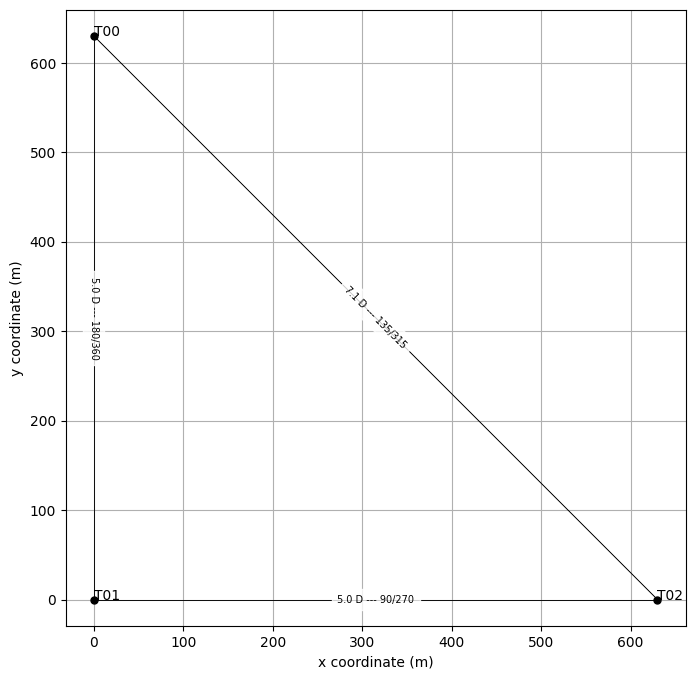

In [6]:


file_path = Path.cwd()
fi_path = file_path / "../examples/floris_input_artificial/gch.yaml"
print(fi_path)
fi = wfct.floris_interface.FlorisInterface(fi_path)
fi.reinitialize(layout_x = [0, 0, 5*126], layout_y = [5*126, 0, 0])

# # Show the wind farm
plot_layout_with_waking_directions(fi)



Num Points 500


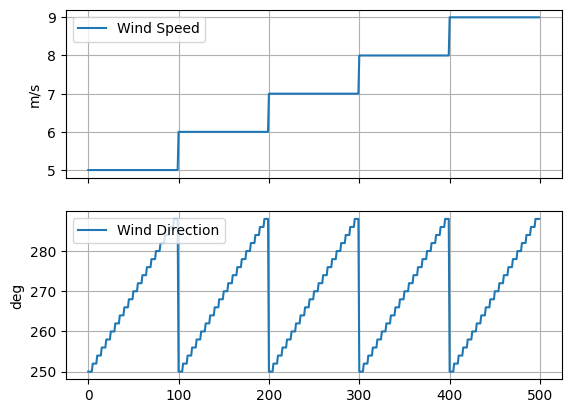

In [7]:
# Create a time history of points where the wind speed and wind direction step different combinations
ws_points = np.arange(5.0,10.0,1.0)
wd_points = np.arange(250.0, 290.0, 2,)
num_points_per_combination = 5 # How many "seconds" per combination

# I know this is dumb but will come back, can't quite work out the numpy version
ws_array = []
wd_array = []
for ws in ws_points:
    for wd in wd_points:
        for i in range(num_points_per_combination):
            ws_array.append(ws)
            wd_array.append(wd)
t = np.arange(len(ws_array))

print(f'Num Points {len(t)}')

fig, axarr = plt.subplots(2,1,sharex=True)
axarr[0].plot(t, ws_array,label='Wind Speed')
axarr[0].set_ylabel('m/s')
axarr[0].legend()
axarr[0].grid(True)
axarr[1].plot(t, wd_array,label='Wind Direction')
axarr[1].set_ylabel('deg')
axarr[1].legend()
axarr[1].grid(True)

In [9]:
# Compute the power of the second turbine for two cases
# Baseline: The front turbine is aligned to the wind
# WakeSteering: The front turbine is yawed 25 deg
fi.reinitialize(wind_speeds=ws_array, wind_directions=wd_array, time_series=True)
fi.calculate_wake()
power_baseline_ref = fi.get_turbine_powers().squeeze()[:,0].flatten() / 1000.
power_baseline_control = fi.get_turbine_powers().squeeze()[:,1].flatten() / 1000.
power_baseline_downstream = fi.get_turbine_powers().squeeze()[:,2].flatten() / 1000.

yaw_angles = np.zeros([len(t),1,3]) * 25
yaw_angles[:,:,1] = 25 # Set control turbine yaw angles to 25 deg
fi.calculate_wake(yaw_angles=yaw_angles)
power_wakesteering_ref = fi.get_turbine_powers().squeeze()[:,0].flatten() / 1000.
power_wakesteering_control = fi.get_turbine_powers().squeeze()[:,1].flatten() /1000.
power_wakesteering_downstream = fi.get_turbine_powers().squeeze()[:,2].flatten() /1000.

## Pandas version (for time)

In [10]:
# Build up the data frames needed for energy ratio suite
df_baseline_pd = pd.DataFrame({
    'wd':wd_array,
    'ws':ws_array,
    'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream
})

df_wakesteering_pd = pd.DataFrame({
    'wd':wd_array,
    'ws':ws_array,
    'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream
})

# Create alternative versions of each of the above dataframes where the wd/ws are perturbed by noise
df_baseline_noisy_pd = pd.DataFrame({
    'wd':wd_array + np.random.randn(len(wd_array))*2,
    'ws':ws_array + np.random.randn(len(ws_array)),
    'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream
})

df_wakesteering_noisy_pd = pd.DataFrame({
    'wd':wd_array + np.random.randn(len(wd_array))*2,
    'ws':ws_array + np.random.randn(len(ws_array)),
    'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream
})

color_palette = sns.color_palette("Paired",4)[::-1]

In [11]:
# # Initialize the energy ratio suite object and add each dataframe
# # separately. 
# fsc = energy_ratio_suite.energy_ratio_suite()
# # fsc.add_df(df_baseline_pd, 'Baseline', color_palette[0])
# # fsc.add_df(df_wakesteering_pd, 'WakeSteering', color_palette[1])
# fsc.add_df(df_baseline_noisy_pd, 'Baseline (Noisy)', color_palette[2])
# fsc.add_df(df_wakesteering_noisy_pd, 'WakeSteering (Noisy)', color_palette[3])

In [12]:


# # Print out the energy ratio
# # fsc.print_dfs()


# # Calculate and plot the energy ratio for the downstream turbine [2]
# # With respect to reference turbine [0]
# # datasets with uncertainty quantification using 50 bootstrap samples
# fsc.get_energy_ratios(
#     test_turbines=[2],
#     wd_step=2.0,
#     ws_step=1.0,
#     N=N,
#     percentiles=[5., 95.],
#     verbose=False,
#     num_blocks=10
# )
# print('done')
# # fsc.plot_energy_ratios(superimpose=True)

# fsc.get_energy_ratios_gain(
#     test_turbines=[2],
#     wd_step=2.0,
#     ws_step=1.0,
#     N=N,
#     percentiles=[5., 95.],
#     verbose=False,
#     num_blocks=10
# )

# Polars implementation

In [13]:

# df_energy = erp.get_energy_table([df_baseline_pd, df_wakesteering_pd], ['baseline', 'wakesteering'])
#df_energy = erp.get_energy_table([df_baseline_noisy_pd, df_wakesteering_noisy_pd], ['baseline', 'wakesteering'])
# df_energy = erp.get_energy_table([df_baseline_noisy_pd], ['baseline'])
# df_energy.head()

er_in = EnergyRatioInput([df_baseline_noisy_pd, df_wakesteering_noisy_pd], ['baseline', 'wakesteering'])

In [16]:
# erp.compute_energy_ratio(df_energy, [0], [2], df_names=['Baseline', 'WakeSteering'])

er_out = erp.compute_energy_ratio(er_in,
                                  ['baseline', 'wakesteering'],
                                  # ['baseline'],
                                  test_turbines=[2],
                                  use_predefined_ref=True,
                                  use_predefined_wd=True,
                                  use_predefined_ws=True,
                                  wd_bin_overlap_radius = 0.0,
                                  N=N)

In [17]:
er_out.df_names

['baseline', 'wakesteering']

In [18]:
er_out.df_result

wd_bin,baseline,wakesteering,uplift,baseline_ub,wakesteering_ub,uplift_ub,baseline_lb,wakesteering_lb,uplift_lb,count_baseline,count_wakesteering
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32
245.0,0.999853,0.995956,-0.389721,0.999898,0.998994,-0.090404,0.999826,0.994146,-0.56812,2,2
247.0,0.999619,0.999029,-0.059042,0.999619,0.999045,-0.048535,0.999356,0.997884,-0.147208,4,7
249.0,0.999668,0.996008,-0.366106,0.999734,0.997174,-0.252983,0.999476,0.993813,-0.580086,15,14
251.0,0.998968,0.993315,-0.565868,0.999278,0.996903,-0.230571,0.998968,0.985601,-1.341189,21,17
253.0,0.99608,0.980221,-1.592193,0.997383,0.983785,-1.316344,0.995065,0.975584,-1.957748,27,24
255.0,0.986854,0.972042,-1.500898,0.986854,0.972971,-1.400405,0.983457,0.95693,-2.69729,23,19
257.0,0.929605,0.907451,-2.383117,0.953546,0.912389,-0.294107,0.91508,0.896393,-5.993767,27,31
259.0,0.873653,0.754429,-13.646555,0.900147,0.758922,-13.646555,0.869822,0.738619,-16.646808,19,23
261.0,0.781192,0.640111,-18.059751,0.821567,0.671269,-12.867805,0.747367,0.623206,-22.606686,29,29


In [19]:
_, df_freq_plot, df_min = er_out._compute_df_freq()

# Demo plotting options

<Axes: title={'center': 'Energy Ratio'}, xlabel='Wind Direction (deg)', ylabel='Energy Ratio'>

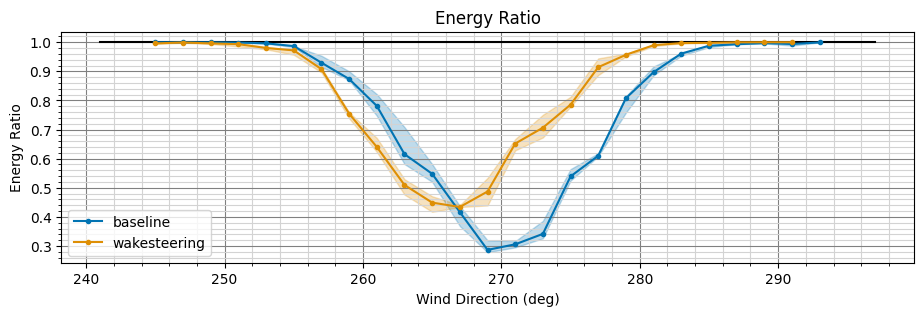

In [20]:
er_out.plot_energy_ratios(show_wind_direction_distribution=False)

baseline baseline
wakesteering wakesteering


array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Number of Points'>],
      dtype=object)

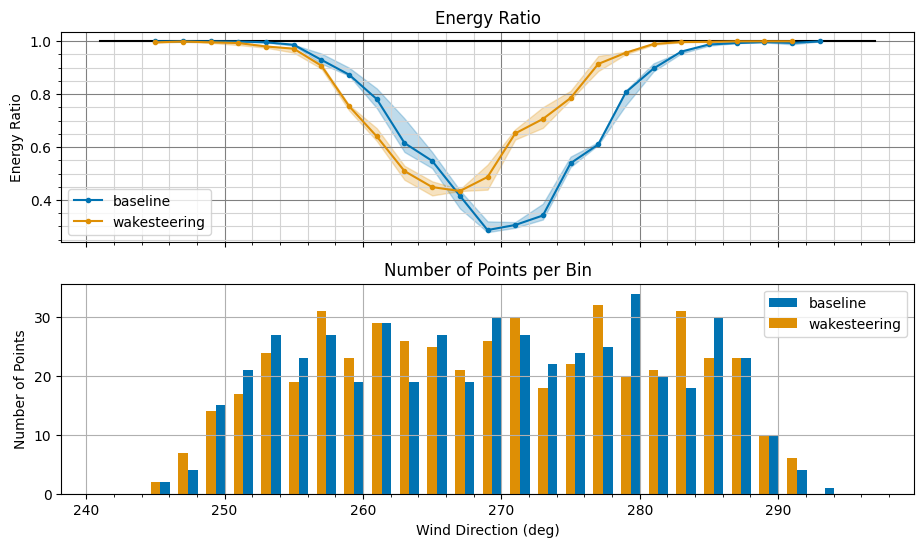

In [21]:
er_out.plot_energy_ratios(show_wind_speed_distribution=False)

baseline baseline
wakesteering wakesteering


array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

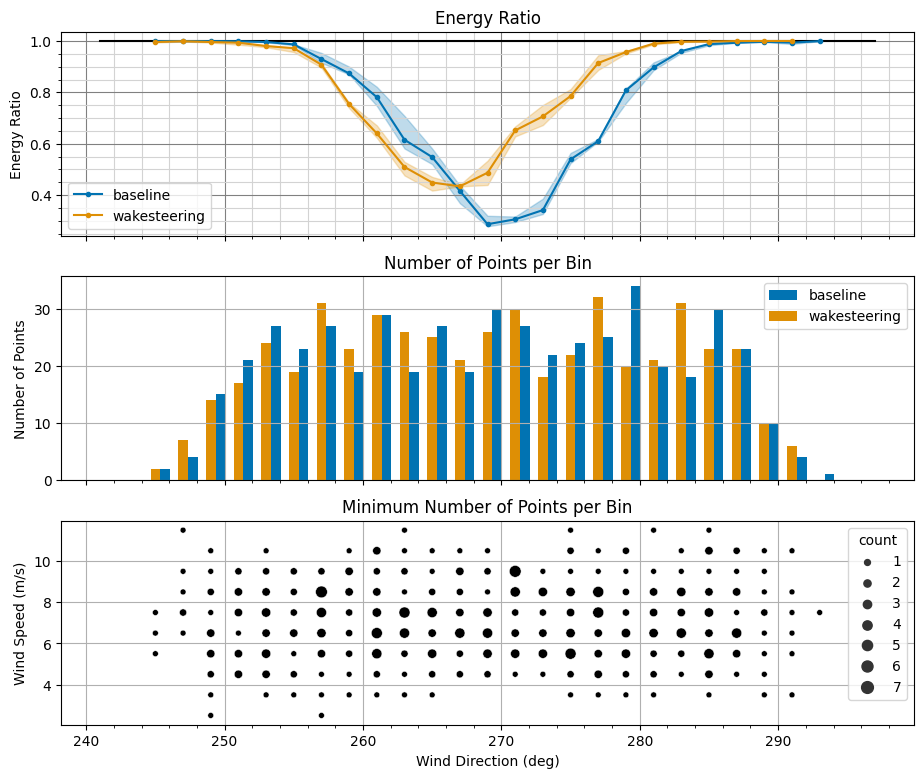

In [22]:
er_out.plot_energy_ratios()

<Axes: title={'center': 'Energy Ratio'}, xlabel='Wind Direction (deg)', ylabel='Energy Ratio'>

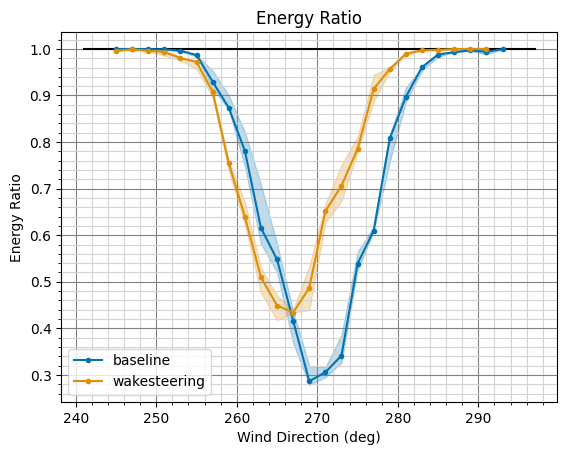

In [23]:
fig, ax = plt.subplots(1,1)
er_out.plot_energy_ratios(show_wind_direction_distribution=False, axarr=ax)

baseline baseline
wakesteering wakesteering


array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Number of Points'>],
      dtype=object)

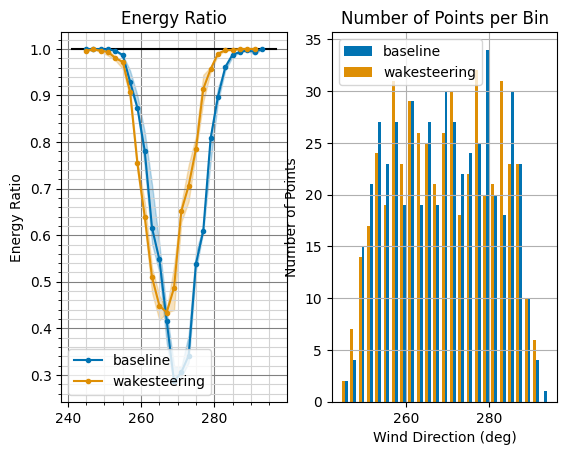

In [24]:
fig, axarr = plt.subplots(1,2)
er_out.plot_energy_ratios(show_wind_speed_distribution=False, axarr=axarr)

<Axes: title={'center': 'Uplift in Energy Ratio'}, xlabel='Wind Direction (deg)', ylabel='Percent Change'>

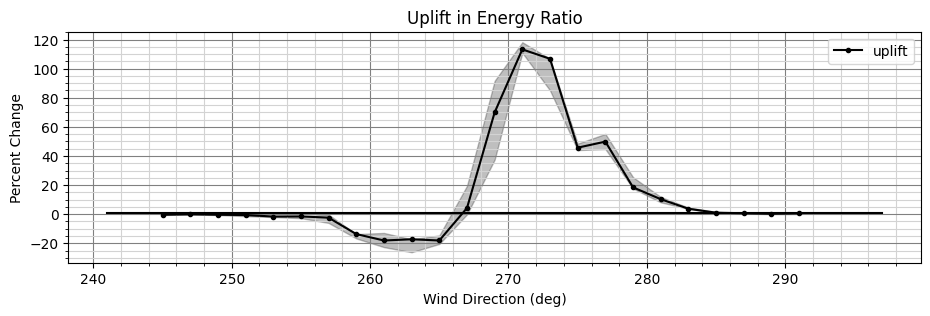

In [25]:
er_out.plot_uplift(show_wind_direction_distribution=False)

uplift uplift


array([<Axes: title={'center': 'Uplift in Energy Ratio'}, ylabel='Percent Change'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

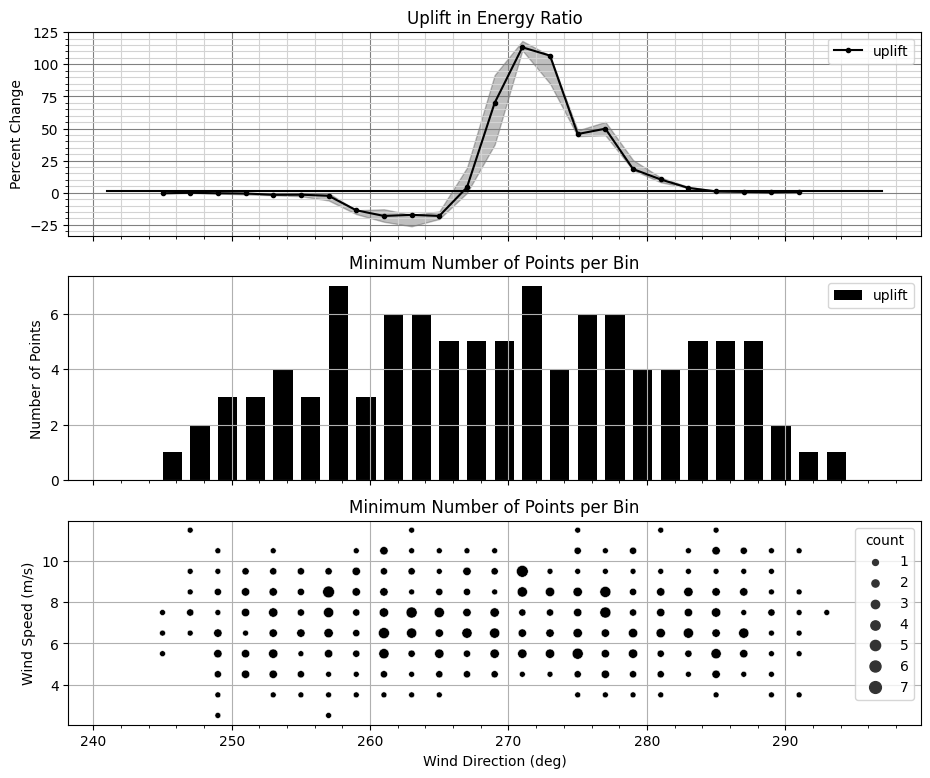

In [26]:
er_out.plot_uplift()

## Compare the energy ratio plots

### Compare the mean values

In [27]:
# df_erb = ero.df_result

# axarr = fsc.plot_energy_ratios(superimpose=True)

# ax = axarr[0]
# ax.plot(df_erb['wd_bin'], df_erb['baseline'], color='k',label='POLARS result (baseline)',ls='--',marker='.')
# # ax.plot(df_erb['wd_bin'], df_erb['wakesteering'], color='k',label='POLARS result (wake steering)',ls='-')

# ax.legend()

### Compare uncertainty bounds

In [28]:
# fig ,ax = plt.subplots()

# # Plot pandas results with uncertainty
# df_pandas_base = fsc.df_list[0]['er_results']
# ax.plot(df_pandas_base['wd_bin'], df_pandas_base['baseline_lb'],'-', color='k', label='PANDAS lower bound')
# ax.plot(df_pandas_base['wd_bin'], df_pandas_base['baseline_ub'],'--', color='k', label='PANDAS upper bound')

# ax.plot(df_erb['wd_bin'], df_erb['baseline_lb'],':', color='r', label='POLARS lower bound')
# ax.plot(df_erb['wd_bin'], df_erb['baseline_ub'],':', color='orange', label='POLARS upper bound')


### Compare the gain values

In [29]:
# fig ,ax = plt.subplots()

# # NOTE THAT PANDAS VERSION IS RATIO WHILE POLARS IS PERCENT CHANGE

# # Plot pandas results with uncertainty
# df_pandas_base = fsc.df_list_gains[0]['er_results']
# ax.plot(df_pandas_base['wd_bin'], df_pandas_base['baseline'],'-', color='k', label='PANDAS')
# ax.fill_between(df_pandas_base['wd_bin'], df_pandas_base['baseline_lb'], df_pandas_base['baseline_ub'], color='k', alpha=0.2)

# ax.plot(df_erb['wd_bin'], df_erb['uplift'] * .01 + 1.0,'--', color='r', label='POLARS')

# ax.plot(df_erb['wd_bin'], df_erb['uplift_lb'] * .01 + 1.0,':', color='r', label='POLARS lower bound')
# ax.plot(df_erb['wd_bin'], df_erb['uplift_ub'] * .01 + 1.0,':', color='orange', label='POLARS upper bound')

# ax.grid(True)
# ax.axhline(1, color='k')


## Test out simley approach to calculating energy ratio uplift in regions

In [24]:

# ero = erp.compute_uplift_in_region(df_energy,
#                              ['baseline', 'wakesteering'],
#                              test_turbines=[2],
#                                   use_predefined_ref=True,
#                                   use_predefined_wd=True,
#                                   use_predefined_ws=True)

# ero.df_result

In [25]:

# ero = erp.compute_uplift_in_region(df_energy,
#                              ['baseline', 'wakesteering'],
#                              test_turbines=[2],
#                                   use_predefined_ref=True,
#                                   use_predefined_wd=True,
#                                   use_predefined_ws=True,
#                                   N=20)

# ero.df_result